In [1]:
import numpy as np
import random
from random import uniform
import matplotlib.pyplot as plt
from math import e

%matplotlib inline

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

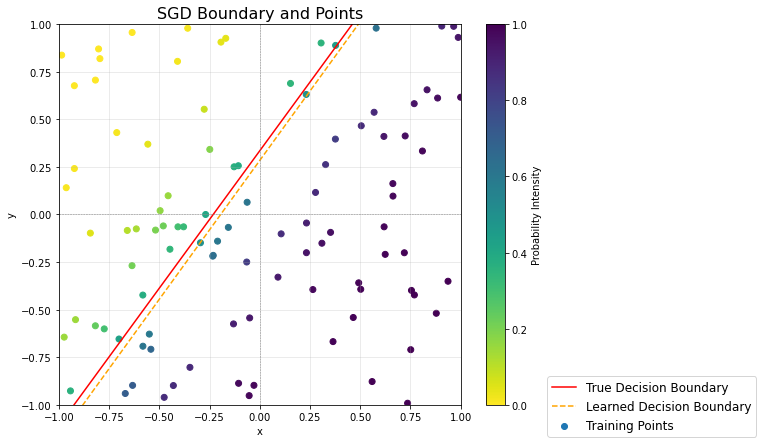

In [6]:
wn, wF, points, y, m, b, epoch, eout = plot_SGD_cm()

In [2]:
def gen_decision_boundary():
    '''Use uniform(-1,1) to generate 2 random points as decision boundary line.'''
    # Generate random line to be used as decision boundary between 0/1
    x1, y1, x2, y2 = [uniform(-1, 1) for i in range(4)]
    m = (y2-y1)/(x2-x1)
    b = y1 - m * x1
    wF = np.array([1, (y2-y1)/(y1*x2-x1*y2), (x1-x2)/(y1*x2-x1*y2)])

    return m, b, wF, x1, y1, x2, y2

def gen_points(num_points=100):
    '''Generates a random set of points for training and testing.'''
    # Generate random points throughout domain space
    points = [(uniform(-1, 1), uniform(-1, 1)) for _ in range(num_points)]

    return points

def run_SGD(N=100, η=0.01, threshold=0.01, max_epochs=1000):
    '''Runs a single experiment of epoch-based Stochastic Gradient Descent
       N = no. of training points
       η = learning rate
       threshold = termination threshold when comparing weight updates between epochs
       max_epochs = exit program if exceeded.'''
    
    m, b, wF, x1, y1, x2, y2 = gen_decision_boundary()
    points = gen_points()
    
    # Initialize weights at t=0 to w(0)
    wn = np.array([0.0, 0.0, 0.0])
    
    # Intialize counter to count epochs
    epoch = 0
    
    # Separate variable to store computed weight at the end of each epoch
    # Copy initial weights as epoch 0 weight vector
    wt = wn.copy()
    
    # Convert to x matrix format with constant weight [ [1, x1, x2], ...]
    xn = np.array([ (1,*p) for p in points])
    
    # Compute signal s = wT.x
    s = np.array([wF.T @ x_arr for x_arr in xn])
    
    # Compute y = sign(s)
    y = np.sign(s)
    
    # Initialize eout and no. of test points
    eout = 0
    n_test = 10**4
    
    # Stop when |w(t+1)-w(t)| < 0.01
    while True:
        
    # Go through all N points in shuffled order
        n_arr = np.random.permutation(N)
    
        for n in n_arr:
            # Compute dE_dw of randomly chosen point
            dE_dw = -(y[n] * xn[n]) / (1+e**(y[n] * wn.T @ xn[n]))
            
            # Update weight vector within epoch
            wn -= η * dE_dw

        # Check norm of difference of weight vectors between adj epochs against threshold
        if np.linalg.norm(wn - wt) < threshold:
            
            # Generate 10k points to estimate Eout
            # Converting test points to xmatrix, ymatrix format
            points_test = gen_points(n_test)
            xn_t = np.array([ (1,*p) for p in points_test])
            s_t = np.array([wF.T @ x_n for x_n in xn_t])
            y_t = np.sign(s_t)
            
            for n in range(len(points_test)):
                eout += np.log(1+e**(-y_t[n] * wn.T @ xn_t[n])) / n_test
            break

        # If still above threshold, update epoch wt
        wt = wn.copy()
        epoch +=1

        # Stop algorithm if above maximum apoch
        if epoch > max_epochs:
            print(f"Maximum epochs reached: {max_epochs}")
            break

    return wn/wn[0], epoch, eout, points, y, m, b, wF

def plot_SGD():
    '''Plots a single run of our SGD program, visualizing the true and learned decision boundary against
       our training points.'''
    wn, epoch, eout, points, y, m, b, wF = run_SGD()
    
    # Separate points into "Above" and "Below"
    # Above points is sign(wF^T.X) = +1, doesn't necessarily mean above decision line y > mx + b
    above_points = [p for p, label in zip(points, y) if label == 1]
    below_points = [p for p, label in zip(points, y) if label == -1]
    
    # Define the line based on m and b
    line_x = np.array([-1, 1])  # X-coordinates for the line
    line_y_true = -(wF[1]/wF[2])*line_x + (-wF[0]/wF[2])
    line_y_learn = -(wn[1]/wn[2])*line_x + (-wn[0]/wn[2])

    
    # Plot the lines
    plt.figure(figsize=(9, 7));
    plt.plot(line_x, line_y_true, label="True Decision Boundary", color='red')
    plt.plot(line_x, line_y_learn, label="Learned Decision Boundary", color='orange', linestyle='--')

    # Plot points
    if above_points:  # Ensure there are points above
        plt.scatter(*zip(*above_points), color='blue', label="1")

    if below_points:  # Ensure there are points below
        plt.scatter(*zip(*below_points), color='green', label="0")
        
    # Formatting
    plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.legend(loc="lower right", bbox_to_anchor=(1.5, -0.1), fontsize=12)
    plt.title("SGD Boundary and Points", fontsize=16)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(alpha=0.3)

    plt.show()
    
    return wn, wF

In [3]:
def θ(s):
    '''Sigmoid function to convert signal to probability in logistic regression.'''
    return (np.exp(s))/(1+np.exp(s))

wn, epoch, eout, points, y, m, b, wF = run_SGD()
X = np.array([ (1,*p) for p in points])
s = np.array([wn.T @ xn for xn in X])
h = θ(s)

def plot_SGD_cm():
    '''Plots a single run of our SGD program, visualizing both the true and learned decision boundary.
       Our training points are also plotted against a colormap scaling with their predicted 
       probabilities.'''
    
    wn, epoch, eout, points, y, m, b, wF = run_SGD()
    
    probabilities = θ(np.dot(np.array([ (1,*p) for p in points]), wn))
    
    # Use reversed colormap to ensure higher probabilities correspond to darker colors
    plt.figure(figsize=(9, 7))
    scatter = plt.scatter(*zip(*points), c=probabilities, cmap='viridis_r', label="Training Points", vmin=0, vmax=1)
    
    line_x = np.array([-1, 1])
    # True Decision boundary
    line_y_true = -(wF[1]/wF[2])*line_x + (-wF[0]/wF[2])
    # Learned Decision boundary
    line_y_learn = -(wn[1]/wn[2])*line_x + (-wn[0]/wn[2])

    plt.plot(line_x, line_y_true, label="True Decision Boundary", color='red')
    plt.plot(line_x, line_y_learn, label="Learned Decision Boundary", color='orange', linestyle='--')
    
    cbar = plt.colorbar(scatter)
    cbar.set_label('Probability Intensity')

    plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.legend(loc="lower right", bbox_to_anchor=(1.75, -0.1), fontsize=12)
    plt.title("SGD Boundary and Points", fontsize=16)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(alpha=0.3)

    plt.show()
    
    return wn, wF, points, y, m, b, epoch, eout

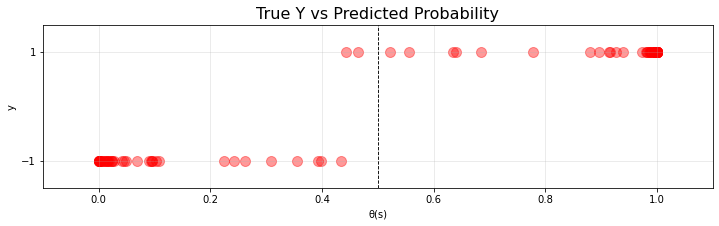

In [4]:
# Visualize predicted probabilities versus actual decision class

plt.figure(figsize=(12, 3));
# plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')
plt.axvline(0.5, color='black', linewidth=0.9, linestyle='--')
plt.xlim(-0.1, 1.1)
plt.ylim(-1.5, 1.5)
plt.yticks([-1, 1])
plt.title("True Y vs Predicted Probability", fontsize=16)
plt.xlabel("θ(s)")
plt.ylabel("y")
plt.grid(alpha=0.3)
plt.scatter(h, y, s=100, alpha=0.4, color='red')
plt.show()